In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv
import shutil

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats
from nipype.workflows.fmri.fsl import create_susan_smooth
from nipype.algorithms.misc import TSNR
from nipype.algorithms.misc import AddCSVColumn
from nipype.algorithms.misc import AddCSVRow

%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,4))
exps = ['ser','sim']
rois = ['mOFC_fill','lOFC_fill']

In [170]:
def extract_mean_tsnr(in_tuple):
    sub,exp,run = in_tuple

    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/'
    mask_dir = home_dir + 'data/' + sub + '/masks/'
    data_path = home_dir + '/data/' + sub + '/func/' + exp + '/run_' + run +  '_fc_crop.nii.gz'

    if os.path.exists(sub_path):
        wf = Workflow(name = 'tsnr')
        wf.basedir = abspath('fd/data/')

        ##set up tsnr calculation
#         preproc_data = sub_path + 'unsmoothed_timeseries.nii.gz'
        tsnr = Node(TSNR(in_file = data_path),name='tsnr')   

        ##set up ROI calculation

        for mask in rois:
#             out_dir = mask_dir + 'OFC/'
#             if not os.path.exists(out_dir):
#                 os.mkdir(out_dir)
            out_tuple = (sub,exp,run,mask)
            out_tuple = ('_').join(map(str,out_tuple))
#             out_f = out_dir + ('').join(map(str,out_tuple))+ '.txt'

            mask_file = mask_dir + mask + '_' + exp  + '.nii.gz'
            
#             meants = Node(ImageMeants(eig = True, order = 1, 
#                      mask = mask_file, out_file = out_f),name='meants' + mask)
#             wf.connect(tsnr,"tsnr_file" ,meants,"in_file")
            stats = Node(ImageStats(mask_file = mask_file,
                                    op_string ='-k %s -M'),name='stats' + mask)
            wf.connect(tsnr,"tsnr_file" ,stats,"in_file")

        ##set up Data Sink
#             sinker = Node(DataSink(), name = 'sinker' + mask)
#             sinker.inputs.base_directory = abspath('tsnr')
#             wf.connect(stats,"out_stat",sinker,'tsnr.@par')
            csv_file= abspath('analysis/OFC_stats.csv')      
            addrow = Node(AddCSVRow(in_file = csv_file),
                          name = 'addcol' + mask)
            addrow.inputs.sub = sub
            addrow.inputs.run = run
            addrow.inputs.exp = exp
            
            wf.connect(stats,"out_stat",addrow,'tsnr')

#         #visualize workflow
        wf.write_graph('workflow_graph.dot')
        Image(filename = 'workflow_graph.dot.png' ) 

        wf.run()

In [171]:
in_tuples = []
for sub in sub_list:
    for exp in exps:
        for run in runs:
            in_tuples.append((sub,exp,run))  
extract_mean_tsnr(in_tuples[0])

INFO:workflow:Converting dotfile: /data/home/iballard/fd/workflow_graph.dot to png format
INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node tsnr in dir: /tmp/tmpP53mw2/tsnr/tsnr
INFO:workflow:Executing node statslOFC_fill in dir: /tmp/tmp4HLPut/tsnr/statslOFC_fill
INFO:workflow:Running: fslstats /tmp/tmpP53mw2/tsnr/tsnr/run_1_fc_crop_tsnr.nii.gz -k /data/home/iballard/fd/data/fd_104/masks/lOFC_fill_ser.nii.gz -M 
INFO:interface:stdout 2015-07-07T14:52:52.169633:13.568572 
INFO:workflow:Executing node statsmOFC_fill in dir: /tmp/tmpifAqP5/tsnr/statsmOFC_fill
INFO:workflow:Running: fslstats /tmp/tmpP53mw2/tsnr/tsnr/run_1_fc_crop_tsnr.nii.gz -k /data/home/iballard/fd/data/fd_104/masks/mOFC_fill_ser.nii.gz -M 
INFO:interface:stdout 2015-07-07T14:52:52.572884:12.663603 
INFO:workflow:Executing node addcolmOFC_fill in dir: /tmp/tmpT_mjX_/tsnr/addcolmOFC_fill
INFO:workflow:Executing node addcollOFC_fill in dir: /tmp/tmpFFslen/tsnr/add

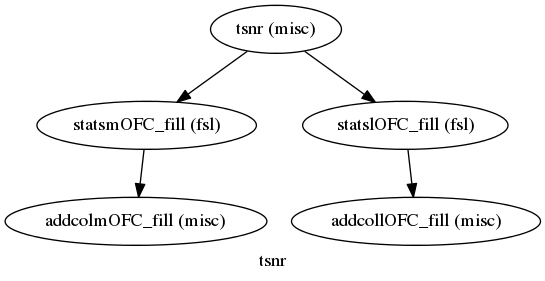

In [130]:
Image(filename = 'workflow_graph.dot.png' ) 